# 4. 建模与验证

## 📋 完整流程说明

本 notebook 基于已准备好的 `model_data_with_labels.csv` 文件进行建模和验证。

### 数据文件说明
- **输入文件**: `data/model_data_with_labels.csv`
  - 包含所有特征（Prepared Remarks 和 Q&A 分开的特征列）
  - 包含 EPS Beat/Miss Label (`eps_beat`)
  - 包含新特征：`sentiment_divergence`, `qa_word_ratio`, `delta_net_sentiment`, `delta_complexity`

### 建模流程

1. **步骤 1: 加载数据**
   - 从 `model_data_with_labels.csv` 加载数据
   - 检查数据完整性

2. **步骤 1.5: 添加新特征**（可选，如果文件中没有）
   - `sentiment_divergence`: Prepared Remarks 与 QA 的情感差
   - `qa_word_ratio`: QA 词数 / Prepared Remarks 词数
   - `delta_net_sentiment`: 标准化净情感变动（Z-score）
   - `delta_complexity`: 标准化复杂度变动（Z-score）

3. **步骤 2: 特征探索与选择**
   - 计算特征与 `eps_beat` 的相关性
   - 绘制 Box Plot 可视化特征分布
   - 选择有用的特征（相关性高、分布差异明显的）

4. **步骤 3: 时间序列切分**
   - 找到所有 ticker 都有的共同季度（balanced panel）
   - 按时间排序，前一半训练，后一半测试

5. **步骤 4: 模型训练**
   - Logistic 回归模型训练
   - 特征标准化
   - 预测概率

6. **步骤 5: 模型评估**
   - LogLoss, Brier Score
   - ROC AUC
   - 概率校准曲线
   - 生成最终概率结果表

In [1]:
import os
import sqlite3
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    log_loss,
    brier_score_loss,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path("..").resolve()
DB_PATH = PROJECT_ROOT / "data" / "earnings_calls.db"
LABEL_DIR = PROJECT_ROOT / "data" / "labels"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DB_PATH:", DB_PATH)

PROJECT_ROOT: /Users/xinyuewang/Desktop/1.27
DB_PATH: /Users/xinyuewang/Desktop/1.27/data/earnings_calls.db


In [2]:
# ========== 此 cell 已删除：旧代码（load_segments_and_features）==========
# 现在直接使用 model_data_with_labels.csv，不再需要从 SQLite 读取和合并
# 请运行 Cell 7（步骤 1：加载 model_data_with_labels.csv）

加载了 1218 条 segment 记录
Ticker 数量: 14
Fiscal Quarter 范围: 2013-Q2 到 2026-Q1

Segment 类型分布:
segment_type
Prepared Remarks    610
Q&A                 608
Name: count, dtype: int64


In [3]:
# 2.5. 从 AlphaQuery 获取 EPS Beat/Miss 数据并生成 Label（使用 pd.read_html）

def format_quarter(dt_str):
    """
    将日期转换为 'YYYY-Qn' 格式
    例如: "2024-12-31" -> "2024-Q4"
    """
    try:
        dt = pd.to_datetime(dt_str)
        p = dt.to_period("Q")
        return f"{p.year}-Q{p.quarter}"
    except:
        return None


def fetch_earnings_history_from_alphaquery(ticker: str):
    """
    从 AlphaQuery 获取某个 ticker 的 earnings history
    使用 pd.read_html() 直接读取表格
    返回 DataFrame，包含：Fiscal Quarter End, Estimated EPS, Actual EPS
    """
    url = f"https://www.alphaquery.com/stock/{ticker}/earnings-history"
    
    try:
        print(f"正在从 AlphaQuery 抓取 {ticker} 的 EPS 数据...")
        # pd.read_html 会自动解析网页中的表格
        tables = pd.read_html(url)
        
        if not tables:
            print(f"⚠️ {ticker}: 未找到表格")
            return None
        
        # 通常第一个表格就是 earnings history
        eps_data = tables[0].copy()
        
        # 清洗列名（去掉多余空格）
        eps_data.columns = [c.strip() for c in eps_data.columns]
        
        # 只保留需要的列
        needed_cols = ["Fiscal Quarter End", "Estimated EPS", "Actual EPS"]
        available_cols = [c for c in needed_cols if c in eps_data.columns]
        
        if not available_cols:
            print(f"⚠️ {ticker}: 表格列名不匹配，可用列: {eps_data.columns.tolist()}")
            return None
        
        eps_data = eps_data[available_cols].copy()
        
        # 处理金钱符号 $ 和逗号，转为数字
        for col in ["Estimated EPS", "Actual EPS"]:
            if col in eps_data.columns:
                eps_data[col] = (
                    eps_data[col].astype(str)
                    .str.replace(r'[$,]', '', regex=True)
                )
                eps_data[col] = pd.to_numeric(eps_data[col], errors="coerce")
        
        # 生成匹配键：将 'Fiscal Quarter End' 转为 '2024-Q1' 这种格式
        eps_data["fiscal_quarter"] = eps_data["Fiscal Quarter End"].apply(format_quarter)
        eps_data["ticker"] = ticker.upper()
        
        # 重命名列以统一格式
        eps_data = eps_data.rename(columns={
            "Fiscal Quarter End": "fiscal_quarter_end",
            "Estimated EPS": "estimated_eps",
            "Actual EPS": "actual_eps"
        })
        
        print(f"✅ {ticker}: 获取了 {len(eps_data)} 条 earnings 记录")
        return eps_data
        
    except Exception as e:
        print(f"❌ {ticker}: 获取数据失败 - {e}")
        return None


def fetch_all_tickers_earnings(ticker_list):
    """
    批量获取所有 ticker 的 earnings history
    """
    all_data = []
    
    for ticker in ticker_list:
        df_ticker = fetch_earnings_history_from_alphaquery(ticker)
        if df_ticker is not None:
            all_data.append(df_ticker)
        
        # 避免请求过快
        import time
        time.sleep(1)
    
    if not all_data:
        return None
    
    df_all = pd.concat(all_data, ignore_index=True)
    return df_all


def generate_eps_labels(df_earnings):
    """
    从 earnings 数据生成 label
    规则：对于某个季度的 earnings call，label 是下个季度是否 beat
    例如：Q1 2024 的 call → Q2 2024 是否 beat
    """
    labels = []
    
    # 按 ticker 分组处理
    for ticker, group in df_earnings.groupby("ticker"):
        # 按 fiscal_quarter_end 排序（从旧到新）
        group = group.sort_values("fiscal_quarter_end")
        
        # 为每个季度计算下个季度是否 beat
        for idx in range(len(group) - 1):
            current_row = group.iloc[idx]
            next_row = group.iloc[idx + 1]
            
            # 当前季度的 fiscal quarter
            current_qtr = current_row["fiscal_quarter"]
            
            if pd.isna(current_qtr):
                continue
            
            # 下个季度的 beat/miss
            if pd.notna(next_row["estimated_eps"]) and pd.notna(next_row["actual_eps"]):
                is_beat = 1 if next_row["actual_eps"] > next_row["estimated_eps"] else 0
                
                labels.append({
                    "ticker": ticker,
                    "fiscal_quarter": current_qtr,
                    "eps_beat": is_beat,
                    "next_quarter_estimated": next_row["estimated_eps"],
                    "next_quarter_actual": next_row["actual_eps"],
                })
    
    df_labels = pd.DataFrame(labels)
    
    if len(df_labels) > 0:
        print(f"\n生成了 {len(df_labels)} 条 label 记录")
        print(f"Beat 数量: {df_labels['eps_beat'].sum()}")
        print(f"Miss 数量: {len(df_labels) - df_labels['eps_beat'].sum()}")
    else:
        print("\n⚠️ 未能生成任何 label 记录")
    
    return df_labels

In [18]:
# 2.6. 执行获取 EPS 数据和生成 Label（运行此 cell）

# 从 SQLite 获取所有 ticker 列表
conn = sqlite3.connect(DB_PATH)
ticker_list = pd.read_sql_query("SELECT DISTINCT ticker FROM segments", conn)['ticker'].tolist()
conn.close()

print(f"需要获取 {len(ticker_list)} 个 ticker 的 EPS 数据: {ticker_list}")

# 检查并备份/删除旧文件
earnings_path = PROJECT_ROOT / "data" / "earnings_history.csv"
if earnings_path.exists():
    import os
    backup_path = PROJECT_ROOT / "data" / "earnings_history_backup.csv"
    os.rename(earnings_path, backup_path)
    print(f"\n✅ 已备份旧文件到: {backup_path}")
    print("将重新获取所有 ticker 的 EPS 数据...")

# 开始获取所有 ticker 的 EPS 数据
print(f"\n开始从 AlphaQuery 获取所有 ticker 的 EPS 数据...")
print("（这可能需要几分钟时间，请耐心等待）")

# 执行获取
df_earnings = fetch_all_tickers_earnings(ticker_list)

if df_earnings is not None:
    # 保存 earnings 数据
    earnings_path.parent.mkdir(parents=True, exist_ok=True)
    df_earnings.to_csv(earnings_path, index=False)
    print(f"\n✅ Earnings 数据已保存到: {earnings_path}")
    print(f"   包含 {df_earnings['ticker'].nunique()} 个 ticker: {sorted(df_earnings['ticker'].unique())}")
else:
    print("❌ 获取 earnings 数据失败")
    df_earnings = None

# 生成 label
if df_earnings is not None and len(df_earnings) > 0:
    print("\n正在生成 label...")
    df_labels = generate_eps_labels(df_earnings)
    
    if len(df_labels) > 0:
        # 保存 label
        label_path = PROJECT_ROOT / "data" / "labels" / "eps_labels.csv"
        label_path.parent.mkdir(parents=True, exist_ok=True)
        df_labels.to_csv(label_path, index=False)
        print(f"\n✅ Label 已保存到: {label_path}")
        
        # 显示前几条记录
        print("\n前5条 label 记录:")
        print(df_labels.head())
        
        # 显示统计信息
        print(f"\n按 ticker 统计:")
        print(df_labels.groupby('ticker')['eps_beat'].agg(['count', 'sum', 'mean']).round(3))
    else:
        print("⚠️ 未能生成 label 记录")
else:
    print("⚠️ 无法生成 label，因为缺少 earnings 数据")

需要获取 14 个 ticker 的 EPS 数据: ['BAC', 'BK', 'BLK', 'BR', 'C', 'DAL', 'GS', 'JPM', 'MS', 'MTB', 'PNC', 'STT', 'TSM', 'WFC']

开始从 AlphaQuery 获取所有 ticker 的 EPS 数据...
（这可能需要几分钟时间，请耐心等待）
正在从 AlphaQuery 抓取 BAC 的 EPS 数据...
❌ BAC: 获取数据失败 - IncompleteRead(22528 bytes read)
正在从 AlphaQuery 抓取 BK 的 EPS 数据...
✅ BK: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 BLK 的 EPS 数据...
✅ BLK: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 BR 的 EPS 数据...
✅ BR: 获取了 44 条 earnings 记录
正在从 AlphaQuery 抓取 C 的 EPS 数据...
✅ C: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 DAL 的 EPS 数据...
✅ DAL: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 GS 的 EPS 数据...
✅ GS: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 JPM 的 EPS 数据...
✅ JPM: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 MS 的 EPS 数据...
✅ MS: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 MTB 的 EPS 数据...
✅ MTB: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 PNC 的 EPS 数据...
✅ PNC: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 STT 的 EPS 数据...
✅ STT: 获取了 45 条 earnings 记录
正在从 AlphaQuery 抓取 TSM 的 EPS 数据...
✅ TSM: 获取了 45 条 earnings 记录
正在从 Al

## 📋 完整建模流程说明

### 步骤概览：

1. **准备数据**
   - ✅ 从 SQLite 读取文本特征（X features）
   - ✅ 从 AlphaQuery 获取 EPS Beat/Miss Label（Y = 1/0）
   - ✅ 合并：将 label 合并到 feature 表格，形成 `df_model`

2. **特征探索与选择**
   - 计算每个 feature 与 `eps_beat` 的相关性
   - 绘制 Box Plot 可视化：Beat vs Miss 的特征分布差异
   - 选择有用的特征（相关性高、分布差异明显的）

3. **模型训练**
   - 时间序列切分：训练集 / 验证集 / 测试集（样本外）
   - Logistic 回归训练
   - 预测下个季度 Beat 的概率

4. **模型评估**
   - LogLoss, Brier Score
   - 概率校准曲线
   - 生成最终概率结果表

---

### 当前步骤：**步骤 2 - 特征探索与选择**

In [19]:
# ========== 此 cell 已删除：旧代码（旧的步骤1：从SQLite读取和合并）==========
# 现在直接使用 model_data_with_labels.csv，不再需要从 SQLite 读取和合并
# 请运行 Cell 7（步骤 1：加载 model_data_with_labels.csv）

步骤 1: 准备数据（合并特征和 Label）

【1.1】从 SQLite 读取 segments 和 features...
✅ 加载了 1218 条 segment 记录（已包含所有 features）

【1.2】按 ticker + fiscal_quarter 聚合特征...
✅ 聚合后共有 605 个 earnings call
   - 原始特征数: 26
   - 新特征列数: 52 (每个特征拆分为 _preparedremark 和 _QA)
   - 特征示例: ['n_words_preparedremark', 'n_words_QA', 'n_sentences_preparedremark', 'n_sentences_QA', 'avg_words_per_sentence_preparedremark']...

【1.3】加载 EPS Beat/Miss Label...
✅ Label 加载成功: 568 条记录
   - Beat 数量: 467
   - Miss 数量: 101

【1.4】合并特征和 Label...
✅ 合并完成！
   - 合并前: df_calls 605 条, df_labels 568 条
   - 合并后: 539 条记录（有 label 的 call）

✅ 数据准备完成！
   - 总记录数: 539
   - 总列数: 55
   - 元数据列数: 2
   - Y label 列数: 1
   - X features 列数: 52
   - X features 示例: ['n_words_preparedremark', 'n_words_QA', 'n_sentences_preparedremark', 'n_sentences_QA', 'avg_words_per_sentence_preparedremark']...
   - Beat 数量: 444
   - Miss 数量: 95
   - Beat 比例: 82.37%

前5行数据预览（包含 X features 和 Y label）:
  ticker fiscal_quarter  eps_beat  n_words_preparedremark  n_words_QA  \
0     BK      

In [32]:
# ========== 步骤 1: 加载 model_data_with_labels.csv ==========

print("=" * 60)
print("步骤 1: 加载数据（从 model_data_with_labels.csv）")
print("=" * 60)

# 直接加载已准备好的数据文件
model_data_path = PROJECT_ROOT / "data" / "model_data_with_labels.csv"

if model_data_path.exists():
    print(f"\n【1.1】从文件加载数据: {model_data_path}")
    df_model = pd.read_csv(model_data_path)
    
    print(f"✅ 数据加载成功！")
    print(f"   - 总记录数: {len(df_model)}")
    print(f"   - 总列数: {len(df_model.columns)}")
    
    # 分类统计列
    metadata_cols = ['ticker', 'fiscal_quarter']
    y_label_cols = ['eps_beat']
    feature_cols = [c for c in df_model.columns if c not in metadata_cols + y_label_cols]
    
    print(f"   - 元数据列数: {len([c for c in metadata_cols if c in df_model.columns])}")
    print(f"   - Y label 列数: {len([c for c in y_label_cols if c in df_model.columns])}")
    print(f"   - X features 列数: {len(feature_cols)}")
    
    # 检查是否包含新特征
    new_features = ['sentiment_divergence', 'qa_word_ratio', 'delta_net_sentiment', 'delta_complexity']
    has_new_features = all(feat in df_model.columns for feat in new_features)
    
    if has_new_features:
        print(f"   - ✅ 包含新特征: {', '.join(new_features)}")
    else:
        missing_features = [f for f in new_features if f not in df_model.columns]
        print(f"   - ⚠️ 缺少新特征: {', '.join(missing_features)}")
        print(f"     请运行下一个 cell（添加新特征）")
    
    print(f"\n   - Beat 数量: {df_model['eps_beat'].sum()}")
    print(f"   - Miss 数量: {len(df_model) - df_model['eps_beat'].sum()}")
    print(f"   - Beat 比例: {df_model['eps_beat'].mean():.2%}")
    
    # 显示 ticker 分布
    print(f"\n   - Ticker 数量: {df_model['ticker'].nunique()}")
    print(f"   - Ticker 列表: {sorted(df_model['ticker'].unique())}")
    print(f"   - Fiscal Quarter 范围: {df_model['fiscal_quarter'].min()} 到 {df_model['fiscal_quarter'].max()}")
    
    # 显示前几行
    print("\n前5行数据预览:")
    display_cols = ['ticker', 'fiscal_quarter', 'eps_beat', 
                    'n_words_preparedremark', 'n_words_QA',
                    'lm_net_sentiment_preparedremark', 'lm_net_sentiment_QA',
                    'sentiment_divergence', 'qa_word_ratio']
    available_cols = [c for c in display_cols if c in df_model.columns]
    if available_cols:
        print(df_model[available_cols].head())
    
else:
    print(f"\n❌ 数据文件不存在: {model_data_path}")
    print(f"\n请先运行以下步骤生成数据文件：")
    print(f"   1. 运行 Cell 2 和 Cell 3（文本入库与特征工程）")
    print(f"   2. 运行 Cell 4（步骤 2.6：获取 EPS 数据和生成 Label）")
    print(f"   3. 运行旧版本的步骤 1（准备数据并保存 model_data_with_labels.csv）")
    df_model = None


步骤 1: 加载数据（从 model_data_with_labels.csv）

【1.1】从文件加载数据: /Users/xinyuewang/Desktop/1.27/data/model_data_with_labels.csv
✅ 数据加载成功！
   - 总记录数: 539
   - 总列数: 59
   - 元数据列数: 2
   - Y label 列数: 1
   - X features 列数: 56
   - ✅ 包含新特征: sentiment_divergence, qa_word_ratio, delta_net_sentiment, delta_complexity

   - Beat 数量: 444
   - Miss 数量: 95
   - Beat 比例: 82.37%

   - Ticker 数量: 13
   - Ticker 列表: ['BK', 'BLK', 'BR', 'C', 'DAL', 'GS', 'JPM', 'MS', 'MTB', 'PNC', 'STT', 'TSM', 'WFC']
   - Fiscal Quarter 范围: 2014-Q4 到 2025-Q3

前5行数据预览:
  ticker fiscal_quarter  eps_beat  n_words_preparedremark  n_words_QA  \
0     BK        2015-Q1         1                  4084.0      7839.0   
1     BK        2015-Q2         1                  3650.0      6295.0   
2     BK        2015-Q3         1                  3925.0      6047.0   
3     BK        2015-Q4         1                  4360.0      5868.0   
4     BK        2016-Q1         1                   162.0     10617.0   

   lm_net_sentiment_prepared

In [33]:
# ========== 添加新特征：差异性特征和互动特征 ==========

if df_model is not None:
    print("\n" + "=" * 60)
    print("添加新特征：差异性特征和互动特征")
    print("=" * 60)
    
    # 确保 df_model 已排序（按 ticker 和 fiscal_quarter）
    df_model = df_model.sort_values(['ticker', 'fiscal_quarter']).reset_index(drop=True)
    
    # 1. 计算 sentiment_divergence: prepared_remarks 与 QA 环节的情感差
    print("\n【1】计算 sentiment_divergence...")
    df_model['sentiment_divergence'] = (
        df_model['lm_net_sentiment_preparedremark'] - df_model['lm_net_sentiment_QA']
    )
    
    # 2. 计算 qa_word_ratio: QA 环节总词数 / prepared_remarks 总词数
    print("【2】计算 qa_word_ratio...")
    df_model['qa_word_ratio'] = (
        df_model['n_words_QA'] / df_model['n_words_preparedremark']
    )
    
    # 3. 计算 delta_net_sentiment: 使用标准化变动（相对于历史均值的标准化差值）
    print("【3】计算 delta_net_sentiment（标准化变动）...")
    # 先计算当前季度的平均净情感（可以用 prepared 和 QA 的平均值）
    df_model['net_sentiment_avg'] = (
        (df_model['lm_net_sentiment_preparedremark'] + df_model['lm_net_sentiment_QA']) / 2
    )
    
    # 按 ticker 分组，计算标准化变动（Z-score）
    # 方法：使用滚动窗口计算历史均值和标准差，然后计算当前值相对于历史均值的标准化差值
    def calculate_standardized_change(group, col_name, window=4):
        """
        计算标准化变动：当前值相对于历史均值的标准化差值（Z-score）
        window: 使用的历史窗口大小（季度数）
        """
        values = group[col_name].values
        standardized_changes = np.full(len(values), np.nan)
        
        for i in range(len(values)):
            if i < window:
                # 前几个季度，使用已有数据计算均值和标准差
                if i > 0:
                    historical_values = values[:i]
                    if len(historical_values) > 0 and not np.isnan(historical_values).all():
                        mean_val = np.nanmean(historical_values)
                        std_val = np.nanstd(historical_values)
                        if std_val > 0:
                            standardized_changes[i] = (values[i] - mean_val) / std_val
            else:
                # 使用滚动窗口
                historical_values = values[i-window:i]
                if not np.isnan(historical_values).all():
                    mean_val = np.nanmean(historical_values)
                    std_val = np.nanstd(historical_values)
                    if std_val > 0:
                        standardized_changes[i] = (values[i] - mean_val) / std_val
        
        return standardized_changes
    
    df_model['delta_net_sentiment'] = (
        df_model.groupby('ticker')
        .apply(lambda g: pd.Series(calculate_standardized_change(g, 'net_sentiment_avg', window=4), index=g.index))
        .reset_index(level=0, drop=True)
    )
    
    # 4. 计算 delta_complexity: 使用标准化变动（相对于历史均值的标准化差值）
    print("【4】计算 delta_complexity（标准化变动）...")
    # 使用 prepared_remark 的 ARI 作为复杂度指标
    df_model['delta_complexity'] = (
        df_model.groupby('ticker')
        .apply(lambda g: pd.Series(calculate_standardized_change(g, 'ari_preparedremark', window=4), index=g.index))
        .reset_index(level=0, drop=True)
    )
    
    # 删除临时列
    df_model = df_model.drop(columns=['net_sentiment_avg'])
    
    print(f"\n✅ 新特征添加完成！")
    print(f"   - sentiment_divergence: {df_model['sentiment_divergence'].notna().sum()} 个有效值")
    print(f"   - qa_word_ratio: {df_model['qa_word_ratio'].notna().sum()} 个有效值")
    print(f"   - delta_net_sentiment: {df_model['delta_net_sentiment'].notna().sum()} 个有效值")
    print(f"   - delta_complexity: {df_model['delta_complexity'].notna().sum()} 个有效值")
    
    # 显示新特征的统计信息
    print("\n新特征统计摘要:")
    print(df_model[['sentiment_divergence', 'qa_word_ratio', 'delta_net_sentiment', 'delta_complexity']].describe())
    
    # 重新保存更新后的 model_data_with_labels.csv
    model_data_path = PROJECT_ROOT / "data" / "model_data_with_labels.csv"
    df_model.to_csv(model_data_path, index=False)
    print(f"\n✅ 更新后的数据已保存到: {model_data_path}")
    print(f"   - 总列数: {len(df_model.columns)}")
    print(f"   - 新增特征: sentiment_divergence, qa_word_ratio, delta_net_sentiment, delta_complexity")
    
else:
    print("❌ 请先完成步骤 1（准备数据）")



添加新特征：差异性特征和互动特征

【1】计算 sentiment_divergence...
【2】计算 qa_word_ratio...
【3】计算 delta_net_sentiment（标准化变动）...
【4】计算 delta_complexity（标准化变动）...

✅ 新特征添加完成！
   - sentiment_divergence: 538 个有效值
   - qa_word_ratio: 538 个有效值
   - delta_net_sentiment: 512 个有效值
   - delta_complexity: 513 个有效值

新特征统计摘要:
       sentiment_divergence  qa_word_ratio  delta_net_sentiment  \
count            538.000000     538.000000           512.000000   
mean               0.008027       3.928235             0.005365   
std                0.007636      10.151760             3.009119   
min               -0.016091       0.342150           -14.861023   
25%                0.003085       1.567877            -1.002817   
50%                0.007461       2.133821             0.158030   
75%                0.012038       2.815650             1.109134   
max                0.031588      80.679389            20.636921   

       delta_complexity  
count        513.000000  
mean          -0.104344  
std            3.233952

In [34]:
# ========== 步骤 2: 特征探索与选择 ==========

if df_model is not None:
    print("=" * 60)
    print("步骤 2: 特征探索与选择")
    print("=" * 60)
    
    # 2.1 计算相关性
    print("\n【2.1】计算每个特征与 eps_beat 的相关性...")
    
    # 自动提取所有特征列（排除元数据和 label 列）
    # 现在特征列名格式为：feature_preparedremark 和 feature_QA
    metadata_cols = ['ticker', 'fiscal_quarter', 'eps_beat']
    feature_cols = [c for c in df_model.columns if c not in metadata_cols]
    
    # 计算缺失值比例
    missing_ratio = df_model[feature_cols].isnull().mean()
    valid_features = missing_ratio[missing_ratio < 0.5].index.tolist()
    
    print(f"   - 总特征列数: {len(feature_cols)} (包含 _preparedremark 和 _QA 版本)")
    print(f"   - 有效特征数（缺失值 < 50%）: {len(valid_features)}")
    
    # 计算相关性
    correlations = []
    for feat in valid_features:
        # 只使用非缺失值计算相关性
        df_temp = df_model[[feat, 'eps_beat']].dropna()
        if len(df_temp) > 10:  # 至少需要10个样本
            corr = df_temp.corr().iloc[0, 1]
            if not np.isnan(corr):
                correlations.append({
                    'feature': feat,
                    'correlation': corr,
                    'abs_correlation': abs(corr)
                })
    
    # 检查是否有相关性数据
    if len(correlations) == 0:
        print("   ⚠️ 没有找到有效的特征列，请检查 df_model 的列名")
        print(f"   df_model 的所有列: {list(df_model.columns)[:20]}...")
        df_corr = pd.DataFrame()
    else:
        df_corr = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)
    
    if len(df_corr) > 0:
        print(f"\n   - 成功计算相关性的特征数: {len(df_corr)}")
        print("\n   Top 15 相关性特征（按绝对值排序）:")
        print(df_corr.head(15)[['feature', 'correlation']].to_string(index=False))
        
        # 保存相关性结果
        corr_path = PROJECT_ROOT / "data" / "feature_correlations.csv"
        df_corr.to_csv(corr_path, index=False)
        print(f"\n   ✅ 相关性结果已保存到: {corr_path}")
    else:
        print("\n   ⚠️ 无法计算相关性，请检查数据")
        print("   提示：确保 df_model 包含特征列（格式：feature_preparedremark 和 feature_QA）")
    
else:
    print("❌ 请先完成步骤 1（准备数据）")

步骤 2: 特征探索与选择

【2.1】计算每个特征与 eps_beat 的相关性...
   - 总特征列数: 56 (包含 _preparedremark 和 _QA 版本)
   - 有效特征数（缺失值 < 50%）: 56

   - 成功计算相关性的特征数: 46

   Top 15 相关性特征（按绝对值排序）:
                            feature  correlation
          avg_words_per_sentence_QA    -0.141756
                     gunning_fog_QA    -0.141704
                  flesch_kincaid_QA    -0.139456
                             ari_QA    -0.131011
                            smog_QA    -0.125177
        adverb_ratio_preparedremark     0.121316
pronoun_plural_ratio_preparedremark     0.106757
                     flesch_ease_QA     0.101278
     lm_constraining_preparedremark    -0.098212
                     n_sentences_QA     0.095600
                delta_net_sentiment     0.094745
         lm_positive_preparedremark     0.079976
    lm_net_sentiment_preparedremark     0.072167
               sentiment_divergence     0.067991
         n_sentences_preparedremark     0.057095

   ✅ 相关性结果已保存到: /Users/xinyuewang/Desktop/1.27/data

步骤 2.2: Box Plot 可视化 - Beat vs Miss 的特征分布差异

绘制 Top 12 个相关性最高的特征的 Box Plot...

✅ Box Plot 已保存到: /Users/xinyuewang/Desktop/1.27/data/feature_boxplots.png


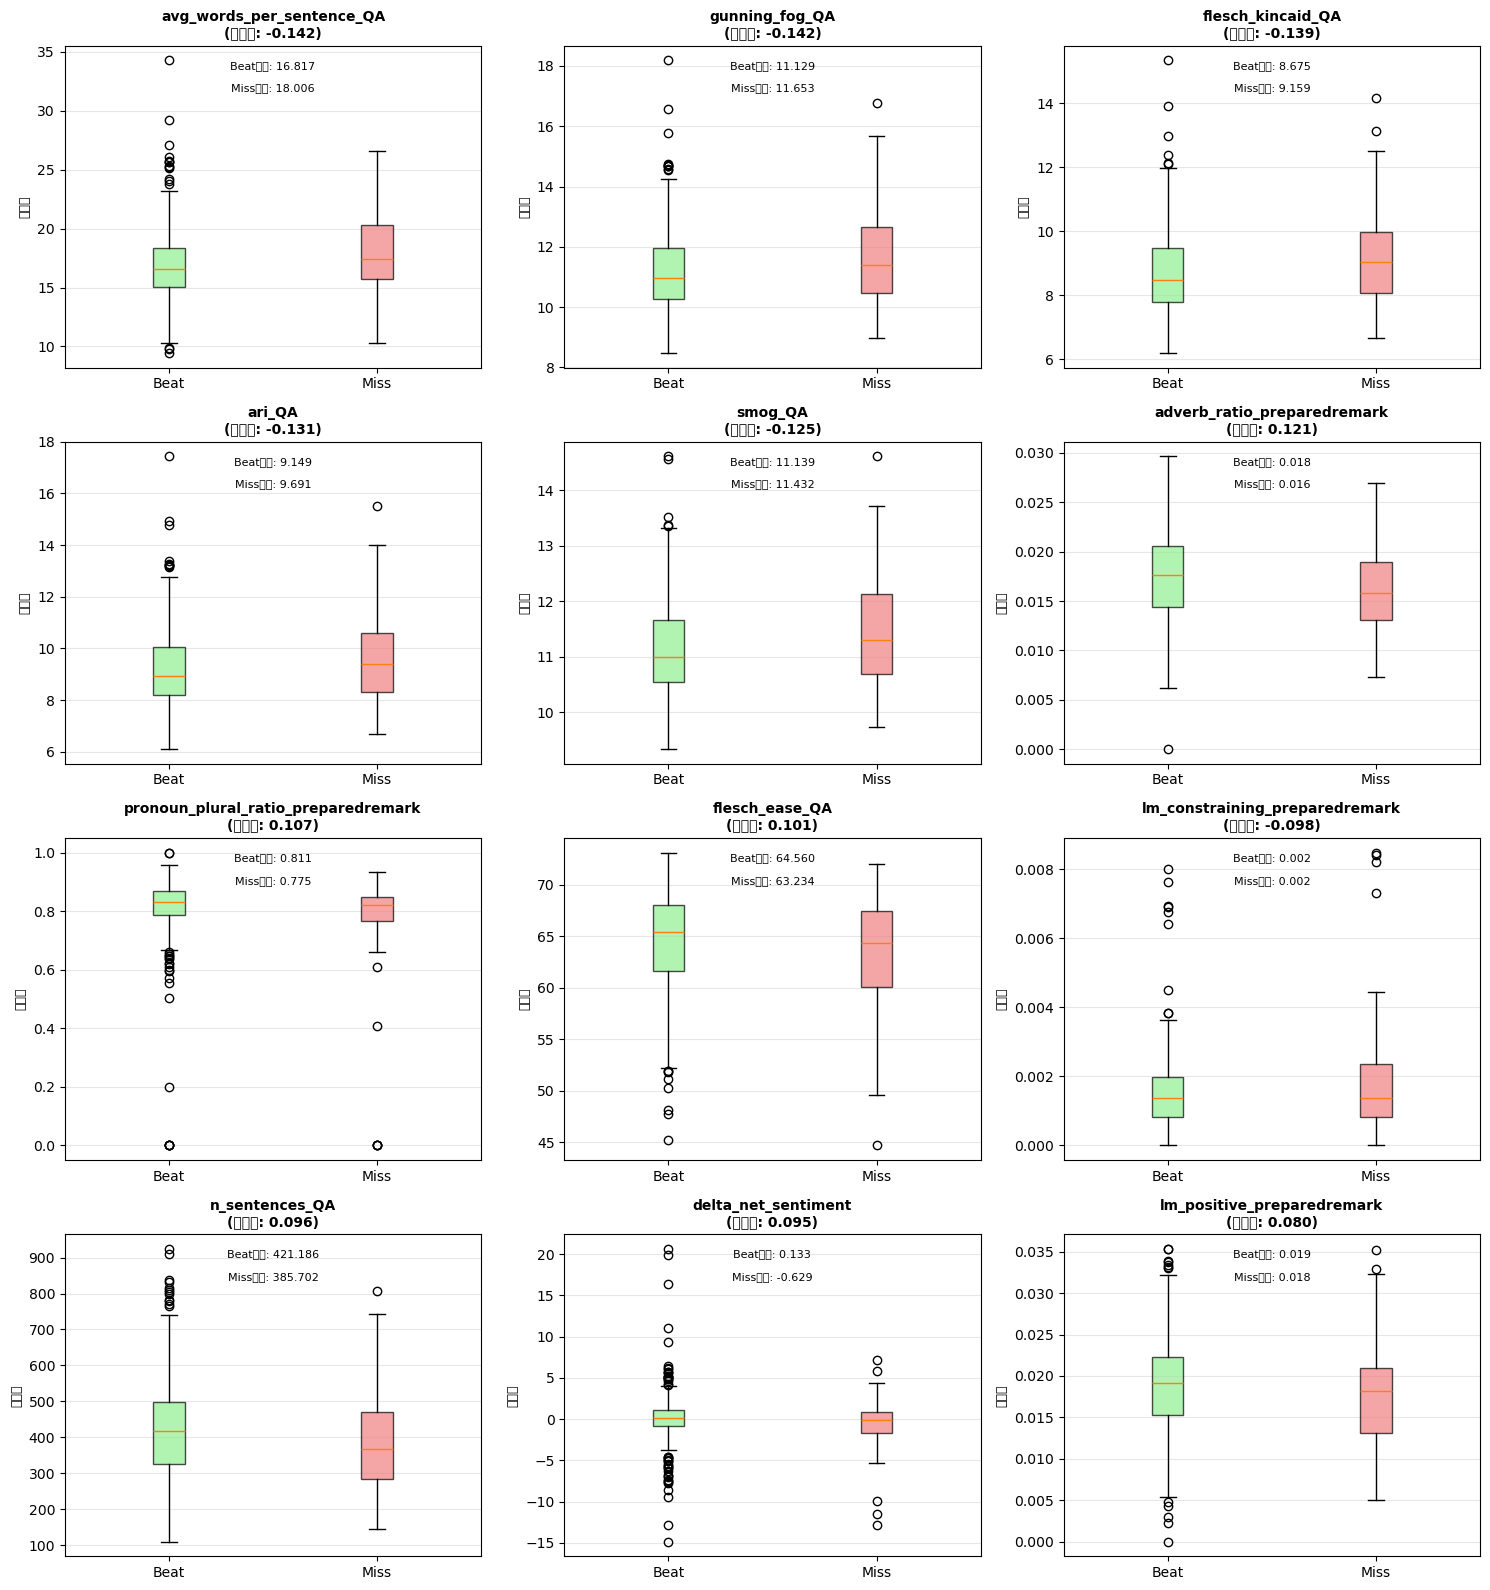


特征分布统计摘要（Beat vs Miss）

【avg_words_per_sentence_QA】
  Beat:  均值=16.8169, 中位数=16.5516, 样本数=444
  Miss:  均值=18.0060, 中位数=17.3959, 样本数=94
  差异:  -1.1891

【gunning_fog_QA】
  Beat:  均值=11.1294, 中位数=10.9736, 样本数=444
  Miss:  均值=11.6529, 中位数=11.4082, 样本数=94
  差异:  -0.5235

【flesch_kincaid_QA】
  Beat:  均值=8.6754, 中位数=8.4797, 样本数=444
  Miss:  均值=9.1588, 中位数=9.0340, 样本数=94
  差异:  -0.4834

【ari_QA】
  Beat:  均值=9.1485, 中位数=8.9344, 样本数=444
  Miss:  均值=9.6912, 中位数=9.3955, 样本数=94
  差异:  -0.5426

【smog_QA】
  Beat:  均值=11.1389, 中位数=10.9955, 样本数=444
  Miss:  均值=11.4321, 中位数=11.3000, 样本数=94
  差异:  -0.2932

【adverb_ratio_preparedremark】
  Beat:  均值=0.0175, 中位数=0.0177, 样本数=444
  Miss:  均值=0.0161, 中位数=0.0158, 样本数=95
  差异:  0.0014


In [35]:
# ========== 步骤 2.2: Box Plot 可视化（Beat vs Miss 的特征分布差异）==========

if df_model is not None and 'df_corr' in locals() and len(df_corr) > 0:
    print("=" * 60)
    print("步骤 2.2: Box Plot 可视化 - Beat vs Miss 的特征分布差异")
    print("=" * 60)
    
    # 选择 Top N 个相关性最高的特征进行可视化
    top_n = 12
    top_features = df_corr.head(top_n)['feature'].tolist()
    
    print(f"\n绘制 Top {top_n} 个相关性最高的特征的 Box Plot...")
    
    # 准备数据：只保留 Beat 和 Miss 的数据
    # 注意：不要对所有列 dropna()，因为每个特征可能有不同的缺失值模式
    df_plot = df_model[top_features + ['eps_beat']].copy()
    
    # 创建子图
    n_cols = 3
    n_rows = (len(top_features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feat in enumerate(top_features):
        ax = axes[idx]
        
        # 准备数据：只对当前特征进行 dropna()，保留尽可能多的样本
        df_feat = df_plot[[feat, 'eps_beat']].dropna()
        beat_data = df_feat[df_feat['eps_beat'] == 1][feat]
        miss_data = df_feat[df_feat['eps_beat'] == 0][feat]
        
        # 绘制 Box Plot
        data_to_plot = [beat_data, miss_data]
        bp = ax.boxplot(data_to_plot, labels=['Beat', 'Miss'], patch_artist=True)
        
        # 美化
        colors = ['lightgreen', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(f"{feat}\n(相关性: {df_corr[df_corr['feature']==feat]['correlation'].values[0]:.3f})", 
                     fontsize=10, fontweight='bold')
        ax.set_ylabel('特征值', fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # 添加统计信息
        beat_mean = beat_data.mean()
        miss_mean = miss_data.mean()
        ax.text(0.5, 0.95, f'Beat均值: {beat_mean:.3f}', 
                transform=ax.transAxes, ha='center', va='top', fontsize=8)
        ax.text(0.5, 0.88, f'Miss均值: {miss_mean:.3f}', 
                transform=ax.transAxes, ha='center', va='top', fontsize=8)
    
    # 隐藏多余的子图
    for idx in range(len(top_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    # 保存图片
    plot_path = PROJECT_ROOT / "data" / "feature_boxplots.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Box Plot 已保存到: {plot_path}")
    
    plt.show()
    
    # 打印统计摘要
    print("\n" + "=" * 60)
    print("特征分布统计摘要（Beat vs Miss）")
    print("=" * 60)
    for feat in top_features[:6]:  # 只显示前6个
        # 只对当前特征进行 dropna()，保留尽可能多的样本
        df_feat = df_plot[[feat, 'eps_beat']].dropna()
        beat_data = df_feat[df_feat['eps_beat'] == 1][feat]
        miss_data = df_feat[df_feat['eps_beat'] == 0][feat]
        
        print(f"\n【{feat}】")
        print(f"  Beat:  均值={beat_data.mean():.4f}, 中位数={beat_data.median():.4f}, 样本数={len(beat_data)}")
        print(f"  Miss:  均值={miss_data.mean():.4f}, 中位数={miss_data.median():.4f}, 样本数={len(miss_data)}")
        print(f"  差异:  {beat_data.mean() - miss_data.mean():.4f}")
        
else:
    print("❌ 请先完成步骤 2.1（计算相关性）")

## 11. 打印模型详细信息

In [ ]:
# ========== 打印模型详细信息 ==========

if 'results' in globals() and results is not None:
    model = results['model']
    scaler = results['scaler']
    
    print("=" * 80)
    print("模型详细信息")
    print("=" * 80)
    
    # 1. 模型类型和基本信息
    print("\n【1. 模型类型】")
    print(f"  模型类型: {type(model).__name__}")
    print(f"  模型类: {type(model)}")
    
    # 2. 模型参数
    print("\n【2. 模型参数】")
    print(f"  C (正则化强度): {model.C}")
    print(f"  penalty (惩罚项): {model.penalty}")
    print(f"  max_iter (最大迭代次数): {model.max_iter}")
    print(f"  random_state (随机种子): {model.random_state}")
    print(f"  solver (求解器): {model.solver}")
    print(f"  tol (收敛容差): {model.tol}")
    print(f"  fit_intercept (是否拟合截距): {model.fit_intercept}")
    print(f"  class_weight (类别权重): {model.class_weight}")
    
    # 3. 模型结构
    print("\n【3. 模型结构】")
    print(f"  特征数量: {len(model.coef_[0])}")
    print(f"  类别数量: {len(model.classes_)}")
    print(f"  类别标签: {model.classes_}")
    print(f"  截距 (intercept): {model.intercept_[0]:.6f}")
    
    # 4. 使用的特征列表
    print("\n【4. 使用的特征列表】")
    if 'selected_features' in globals():
        print(f"  特征总数: {len(selected_features)}")
        print("\n  特征列表:")
        for i, feat in enumerate(selected_features, 1):
            print(f"    {i:2d}. {feat}")
    else:
        print("  ⚠️ 未找到 selected_features 变量")
    
    # 5. 特征系数（权重）
    print("\n【5. 特征系数（权重）】")
    if 'selected_features' in globals() and 'feature_importance' in globals():
        print("\n  所有特征的系数（按绝对值排序）:")
        print(feature_importance.to_string(index=False))
    else:
        print("\n  特征系数:")
        coef_df = pd.DataFrame({
            'feature': selected_features if 'selected_features' in globals() else [f'feature_{i}' for i in range(len(model.coef_[0]))],
            'coefficient': model.coef_[0],
            'abs_coefficient': np.abs(model.coef_[0])
        }).sort_values('abs_coefficient', ascending=False)
        print(coef_df.to_string(index=False))
    
    # 6. Scaler 信息
    print("\n【6. 特征标准化器 (StandardScaler)】")
    print(f"  类型: {type(scaler).__name__}")
    print(f"  均值 (mean): {scaler.mean_[:5] if len(scaler.mean_) > 5 else scaler.mean_}...")
    print(f"  标准差 (scale): {scaler.scale_[:5] if len(scaler.scale_) > 5 else scaler.scale_}...")
    print(f"  特征数量: {len(scaler.mean_)}")
    
    # 7. 模型预测函数
    print("\n【7. 模型预测函数】")
    print(f"  predict(): 预测类别（0或1）")
    print(f"  predict_proba(): 预测概率 [P(Miss), P(Beat)]")
    print(f"  decision_function(): 决策函数值（未归一化的概率）")
    
    # 8. 训练数据统计
    print("\n【8. 训练数据统计】")
    if 'df_train' in globals():
        print(f"  训练样本数: {len(df_train)}")
        print(f"  训练集 Beat 比例: {df_train['eps_beat'].mean():.2%}")
        print(f"  训练集 Beat 数量: {df_train['eps_beat'].sum()}")
        print(f"  训练集 Miss 数量: {(df_train['eps_beat'] == 0).sum()}")
    
    # 9. 模型文件路径
    print("\n【9. 保存的模型文件】")
    model_path = PROJECT_ROOT / "data" / "model.pkl"
    scaler_path = PROJECT_ROOT / "data" / "scaler.pkl"
    features_path = PROJECT_ROOT / "data" / "selected_features.txt"
    print(f"  模型文件: {model_path} ({'✅ 存在' if model_path.exists() else '❌ 不存在'})")
    print(f"  Scaler 文件: {scaler_path} ({'✅ 存在' if scaler_path.exists() else '❌ 不存在'})")
    print(f"  特征列表文件: {features_path} ({'✅ 存在' if features_path.exists() else '❌ 不存在'})")
    
    print("\n" + "=" * 80)
    print("模型信息打印完成")
    print("=" * 80)
    
else:
    print("❌ 未找到训练好的模型，请先运行模型训练的 cell")

In [36]:
# ========== 步骤 2.3: 选择有用的特征 ==========

if df_model is not None and 'df_corr' in locals() and len(df_corr) > 0:
    print("=" * 60)
    print("步骤 2.3: 选择有用的特征")
    print("=" * 60)
    
    # 根据相关性阈值选择特征
    min_correlation = 0.05  # 可以调整这个阈值
    selected_features = df_corr[df_corr['abs_correlation'] > min_correlation]['feature'].tolist()
    
    print(f"\n选择标准: 相关性绝对值 > {min_correlation}")
    print(f"选中的特征数: {len(selected_features)}")
    print(f"\n选中的特征列表:")
    for i, feat in enumerate(selected_features, 1):
        corr_val = df_corr[df_corr['feature']==feat]['correlation'].values[0]
        print(f"  {i:2d}. {feat:25s} (相关性: {corr_val:7.4f})")
    
    # 保存选中的特征列表
    selected_features_path = PROJECT_ROOT / "data" / "selected_features.txt"
    with open(selected_features_path, 'w') as f:
        for feat in selected_features:
            f.write(f"{feat}\n")
    print(f"\n✅ 选中的特征列表已保存到: {selected_features_path}")
    
    print("\n" + "=" * 60)
    print("✅ 步骤 2 完成！特征探索与选择已完成")
    print("=" * 60)
    print("\n下一步: 步骤 3 - 模型训练（运行下面的 cell）")
    
else:
    print("❌ 请先完成步骤 2.1（计算相关性）")

步骤 2.3: 选择有用的特征

选择标准: 相关性绝对值 > 0.05
选中的特征数: 19

选中的特征列表:
   1. avg_words_per_sentence_QA (相关性: -0.1418)
   2. gunning_fog_QA            (相关性: -0.1417)
   3. flesch_kincaid_QA         (相关性: -0.1395)
   4. ari_QA                    (相关性: -0.1310)
   5. smog_QA                   (相关性: -0.1252)
   6. adverb_ratio_preparedremark (相关性:  0.1213)
   7. pronoun_plural_ratio_preparedremark (相关性:  0.1068)
   8. flesch_ease_QA            (相关性:  0.1013)
   9. lm_constraining_preparedremark (相关性: -0.0982)
  10. n_sentences_QA            (相关性:  0.0956)
  11. delta_net_sentiment       (相关性:  0.0947)
  12. lm_positive_preparedremark (相关性:  0.0800)
  13. lm_net_sentiment_preparedremark (相关性:  0.0722)
  14. sentiment_divergence      (相关性:  0.0680)
  15. n_sentences_preparedremark (相关性:  0.0571)
  16. pronoun_plural_ratio_QA   (相关性: -0.0561)
  17. lm_polarity_preparedremark (相关性:  0.0539)
  18. lm_complexity_preparedremark (相关性:  0.0515)
  19. coleman_liau_QA           (相关性: -0.0501)

✅ 选中的特征列表已保存到: /Use

In [27]:
# ========== 此 cell 已删除：旧代码（aggregate_features_by_call）==========
# 此函数使用加权平均合并 Prepared Remarks 和 Q&A 特征，不符合要求
# 现在直接使用 model_data_with_labels.csv，特征已按 _preparedremark 和 _QA 分开存储
# 请运行 Cell 7（步骤 1：加载 model_data_with_labels.csv）


聚合后共有 605 个 earnings call
每个 ticker 的平均 call 数: 43.2


,ticker,fiscal_quarter,call_datetime_et,n_words,n_sentences,avg_words_per_sentence,pronoun_plural_ratio,adverb_ratio,ari,coleman_liau,...,lm_modal_moderate,lm_modal_strong,lm_constraining,lm_complexity,lm_net_sentiment,lm_polarity,lm_subjectivity,has_prepared,has_qa,n_segments
0,BAC,2013-Q2,2013-07-17 08:30,7174.5,377.9,19.101515,0.564853,0.014819,10.270614,8.683436,...,0.0,0.0,0.000721,0.002112,0.003462,0.021145,0.031954,True,True,2
1,BAC,2014-Q2,2014-07-16 08:30,9445.8,416.2,22.039909,0.534719,0.015633,11.716178,9.127881,...,0.0,0.0,0.000371,0.003509,0.000875,0.022713,0.035433,True,True,2
2,BAC,2014-Q3,2014-10-15 08:30,8396.1,445.5,18.492308,0.514838,0.016124,9.999564,8.878937,...,0.0,0.0,0.000554,0.003541,0.001334,0.020743,0.036043,True,True,2
3,BAC,2014-Q4,2015-01-15 08:30,7726.0,280.0,26.867530,0.505827,0.016732,13.788262,9.110363,...,0.0,0.0,0.001422,0.003213,-0.000931,0.023328,0.035548,True,True,2
4,BAC,2015-Q1,2015-04-15 08:30,8059.3,422.7,19.054872,0.557667,0.014814,9.908000,8.396441,...,0.0,0.0,0.001267,0.002860,-0.001061,0.022034,0.034568,True,True,2


In [10]:
# ========== 此 cell 已删除：旧代码（load_eps_labels）==========
# 现在直接使用 model_data_with_labels.csv，label 已经包含在文件中
# 请运行 Cell 7（步骤 1：加载 model_data_with_labels.csv）


加载了 176 条 label 记录
Beat 数量: 142
Miss 数量: 34
请提供 label 文件路径，或手动创建 DataFrame
格式示例:
ticker,fiscal_quarter,eps_beat
BAC,2024-Q1,1
BAC,2024-Q2,0


In [11]:
# ========== 此 cell 已删除：旧代码（merge_features_and_labels）==========
# 现在直接使用 model_data_with_labels.csv，特征和 label 已经合并好了
# 请运行 Cell 7（步骤 1：加载 model_data_with_labels.csv）

合并后有 169 条记录（有 label 的 call）
Beat 比例: 79.88%


In [38]:
# 5. 特征选择（找出有用的特征）

def select_features(df_model, min_correlation: float = 0.05):
    """
    特征选择：
    1. 动态识别所有特征列（包括 _preparedremark, _QA 后缀的特征和新特征）
    2. 计算每个特征与 eps_beat 的相关性
    3. 移除缺失值过多的特征
    4. 选择相关性绝对值 > min_correlation 的特征
    """
    # 元数据列和 label 列（需要排除）
    metadata_cols = ['ticker', 'fiscal_quarter', 'call_datetime_et', 'has_prepared', 'has_qa', 'n_segments']
    label_cols = ['eps_beat']
    exclude_cols = metadata_cols + label_cols
    
    # 动态识别所有特征列：排除元数据和 label 列
    all_cols = df_model.columns.tolist()
    feature_cols = [col for col in all_cols if col not in exclude_cols]
    
    print(f"动态识别的特征列数: {len(feature_cols)}")
    print(f"特征列示例: {feature_cols[:5]}...")
    
    # 计算缺失值比例
    missing_ratio = df_model[feature_cols].isnull().mean()
    
    # 移除缺失值 > 50% 的特征
    valid_features = missing_ratio[missing_ratio < 0.5].index.tolist()
    
    print(f"原始特征数: {len(feature_cols)}")
    print(f"移除缺失值过多特征后: {len(valid_features)}")
    
    # 计算与 eps_beat 的相关性
    correlations = []
    for feat in valid_features:
        # 只使用有 eps_beat 标签的数据计算相关性
        df_temp = df_model[[feat, 'eps_beat']].dropna()
        if len(df_temp) > 0:
            corr = df_temp.corr().iloc[0, 1]
            if not np.isnan(corr):
                correlations.append({
                    'feature': feat,
                    'correlation': corr,
                    'abs_correlation': abs(corr)
                })
    
    if len(correlations) == 0:
        print("\n⚠️ 警告：没有找到有效的相关性数据")
        return [], pd.DataFrame()
    
    df_corr = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)
    
    # 选择相关性绝对值 > min_correlation 的特征
    selected_features = df_corr[df_corr['abs_correlation'] > min_correlation]['feature'].tolist()
    
    print(f"\n相关性 > {min_correlation} 的特征数: {len(selected_features)}")
    if len(df_corr) > 0:
        print("\nTop 10 相关性特征:")
        print(df_corr.head(10)[['feature', 'correlation']])
    else:
        print("\n⚠️ 警告：相关性 DataFrame 为空")
    
    return selected_features, df_corr

# 如果有 df_model，运行特征选择
if 'df_model' in globals() and df_model is not None:
    selected_features, df_corr = select_features(df_model)
else:
    print("❌ 请先完成步骤 1（加载数据）")

动态识别的特征列数: 56
特征列示例: ['n_words_preparedremark', 'n_words_QA', 'n_sentences_preparedremark', 'n_sentences_QA', 'avg_words_per_sentence_preparedremark']...
原始特征数: 56
移除缺失值过多特征后: 56

相关性 > 0.05 的特征数: 19

Top 10 相关性特征:
                                feature  correlation
5             avg_words_per_sentence_QA    -0.141756
21                       gunning_fog_QA    -0.141704
19                    flesch_kincaid_QA    -0.139456
11                               ari_QA    -0.131011
23                              smog_QA    -0.125177
8           adverb_ratio_preparedremark     0.121316
6   pronoun_plural_ratio_preparedremark     0.106757
17                       flesch_ease_QA     0.101278
32       lm_constraining_preparedremark    -0.098212
3                        n_sentences_QA     0.095600


In [39]:
# 6. 时间序列切分（强一致性：只用所有 ticker 都有的共同季度）
# 你的要求：
# - 找到所有 ticker 都有的 fiscal_quarter（取交集）
# - 只用这些季度（balanced panel）
# - 按时间排序后：前一半训练、后一半测试

import re

def _fq_to_index(fq: str) -> int:
    """把 'YYYY-Qn' 映射成可排序的整数：year*4 + (q-1)"""
    m = re.match(r"^(\d{4})-Q([1-4])$", str(fq))
    if not m:
        return -1
    year = int(m.group(1))
    q = int(m.group(2))
    return year * 4 + (q - 1)


def split_time_series(df_model: pd.DataFrame):
    """只用共同季度做 50/50 时间切分。
    返回：df_train, df_val(空), df_test
    """
    df = df_model.copy()

    # 1) 每个 ticker 的季度集合
    per_ticker_quarters = (
        df.groupby('ticker')['fiscal_quarter']
        .apply(lambda s: set(s.dropna().astype(str)))
        .to_dict()
    )
    tickers = sorted(per_ticker_quarters.keys())
    if not tickers:
        raise ValueError('df_model 里没有 ticker')

    # 2) 求交集（共同季度）
    common = None
    for t in tickers:
        common = per_ticker_quarters[t] if common is None else (common & per_ticker_quarters[t])
    common_quarters_sorted = sorted([q for q in common if _fq_to_index(q) >= 0], key=_fq_to_index)

    print('=' * 60)
    print('共同季度（所有 ticker 都有）')
    print('=' * 60)
    print(f'tickers: {tickers}')
    print(f'共同季度数: {len(common_quarters_sorted)}')
    if len(common_quarters_sorted) > 0:
        print(f'共同季度范围: {common_quarters_sorted[0]} -> {common_quarters_sorted[-1]}')
        print(f'共同季度列表: {common_quarters_sorted}')

    if len(common_quarters_sorted) < 2:
        raise ValueError('共同季度太少，无法做时间切分')

    # 3) 只保留共同季度（balanced panel）
    df_bal = df[df['fiscal_quarter'].astype(str).isin(common_quarters_sorted)].copy()

    # 4) 50/50 按时间切分
    n = len(common_quarters_sorted)
    split_idx = n // 2
    train_quarters = common_quarters_sorted[:split_idx]
    test_quarters = common_quarters_sorted[split_idx:]

    df_train = df_bal[df_bal['fiscal_quarter'].astype(str).isin(train_quarters)].copy()
    df_test = df_bal[df_bal['fiscal_quarter'].astype(str).isin(test_quarters)].copy()
    df_val = df_bal.iloc[0:0].copy()  # 你要前半/后半；这里不单独留验证集

    print('=' * 60)
    print('切分结果（前半训练 / 后半测试）')
    print('=' * 60)
    print(f'训练季度数: {len(train_quarters)} -> {train_quarters}')
    print(f'测试季度数: {len(test_quarters)} -> {test_quarters}')
    print(f'训练样本数: {len(df_train)} (期望 {len(train_quarters)} * {len(tickers)} = {len(train_quarters) * len(tickers)})')
    print(f'测试样本数: {len(df_test)} (期望 {len(test_quarters)} * {len(tickers)} = {len(test_quarters) * len(tickers)})')

    # sanity check：每个 ticker 的训练/测试季度数都一致
    print('每个 ticker 训练季度数:', df_train.groupby('ticker')['fiscal_quarter'].nunique().to_dict())
    print('每个 ticker 测试季度数:', df_test.groupby('ticker')['fiscal_quarter'].nunique().to_dict())

    return df_train, df_val, df_test

# 用法：
df_train, df_val, df_test = split_time_series(df_model)


共同季度（所有 ticker 都有）
tickers: ['BK', 'BLK', 'BR', 'C', 'DAL', 'GS', 'JPM', 'MS', 'MTB', 'PNC', 'STT', 'TSM', 'WFC']
共同季度数: 25
共同季度范围: 2016-Q3 -> 2025-Q2
共同季度列表: ['2016-Q3', '2017-Q2', '2017-Q3', '2018-Q1', '2018-Q3', '2019-Q1', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q4', '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1', '2025-Q1', '2025-Q2']
切分结果（前半训练 / 后半测试）
训练季度数: 12 -> ['2016-Q3', '2017-Q2', '2017-Q3', '2018-Q1', '2018-Q3', '2019-Q1', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4']
测试季度数: 13 -> ['2021-Q1', '2021-Q2', '2021-Q4', '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1', '2025-Q1', '2025-Q2']
训练样本数: 156 (期望 12 * 13 = 156)
测试样本数: 169 (期望 13 * 13 = 169)
每个 ticker 训练季度数: {'BK': 12, 'BLK': 12, 'BR': 12, 'C': 12, 'DAL': 12, 'GS': 12, 'JPM': 12, 'MS': 12, 'MTB': 12, 'PNC': 12, 'STT': 12, 'TSM': 12, 'WFC': 12}
每个 ticker 测试季度数: {'BK': 13, '

In [42]:
# 7. Logistic 回归模型训练和预测

def train_logistic_model(df_train, df_val, df_test, selected_features):
    """
    训练 Logistic 回归模型，并在验证集和测试集上预测
    """
    # 准备特征和标签
    X_train = df_train[selected_features].fillna(0)
    y_train = df_train['eps_beat']
    
    X_val = df_val[selected_features].fillna(0) if len(df_val) > 0 else None
    y_val = df_val['eps_beat'] if len(df_val) > 0 else None
    
    X_test = df_test[selected_features].fillna(0) if len(df_test) > 0 else None
    y_test = df_test['eps_beat'] if len(df_test) > 0 else None
    
    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    if X_val is not None:
        X_val_scaled = scaler.transform(X_val)
    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)
    
    # 训练模型
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # 预测概率
    train_probs = model.predict_proba(X_train_scaled)[:, 1]
    
    results = {
        'model': model,
        'scaler': scaler,
        'train': {
            'y_true': y_train.values,
            'y_pred_proba': train_probs
        }
    }
    
    if X_val is not None and y_val is not None:
        val_probs = model.predict_proba(X_val_scaled)[:, 1]
        results['val'] = {
            'y_true': y_val.values,
            'y_pred_proba': val_probs
        }
    
    if X_test is not None and y_test is not None:
        test_probs = model.predict_proba(X_test_scaled)[:, 1]
        results['test'] = {
            'y_true': y_test.values,
            'y_pred_proba': test_probs
        }
    
    # 特征重要性（系数）
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 重要特征（按系数绝对值）:")
    print(feature_importance.head(10))
    
    return results, feature_importance

# 如果有数据，运行训练
results, feature_importance = train_logistic_model(df_train, df_val, df_test, selected_features)

# 保存模型和 scaler，供 5r.ipynb 等预测使用
import pickle
if results is not None:
    model_path = PROJECT_ROOT / "data" / "model.pkl"
    scaler_path = PROJECT_ROOT / "data" / "scaler.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(results['model'], f)
    with open(scaler_path, 'wb') as f:
        pickle.dump(results['scaler'], f)
    print(f"\n✅ 模型已保存: {model_path}")
    print(f"✅ Scaler 已保存: {scaler_path}")


Top 10 重要特征（按系数绝对值）:
                           feature  coefficient  abs_coefficient
18                 coleman_liau_QA     0.712150         0.712150
10             delta_net_sentiment     0.463345         0.463345
8   lm_constraining_preparedremark    -0.456212         0.456212
5      adverb_ratio_preparedremark     0.425533         0.425533
13            sentiment_divergence     0.308088         0.308088
9                   n_sentences_QA     0.276152         0.276152
2                flesch_kincaid_QA    -0.260220         0.260220
14      n_sentences_preparedremark     0.228280         0.228280
17    lm_complexity_preparedremark     0.187188         0.187188
16      lm_polarity_preparedremark    -0.126800         0.126800

✅ 模型已保存: /Users/xinyuewang/Desktop/1.27/data/model.pkl
✅ Scaler 已保存: /Users/xinyuewang/Desktop/1.27/data/scaler.pkl


In [43]:
# 8. 评价指标计算（LogLoss, Brier Score, 校准曲线）

def evaluate_model(results):
    """计算各种评价指标"""
    metrics = {}
    
    for split_name, split_data in results.items():
        if split_name in ['model', 'scaler']:
            continue
            
        y_true = split_data['y_true']
        y_pred_proba = split_data['y_pred_proba']
        
        # LogLoss
        logloss = log_loss(y_true, y_pred_proba)
        
        # Brier Score
        brier = brier_score_loss(y_true, y_pred_proba)
        
        # ROC AUC
        try:
            auc = roc_auc_score(y_true, y_pred_proba)
        except:
            auc = None
        
        # 平均预测概率 vs 实际 Beat 率
        mean_pred_proba = y_pred_proba.mean()
        actual_beat_rate = y_true.mean()
        
        metrics[split_name] = {
            'logloss': logloss,
            'brier_score': brier,
            'roc_auc': auc,
            'mean_pred_proba': mean_pred_proba,
            'actual_beat_rate': actual_beat_rate,
            'calibration_error': abs(mean_pred_proba - actual_beat_rate)
        }
    
    # 打印结果
    df_metrics = pd.DataFrame(metrics).T
    print("\n评价指标:")
    print(df_metrics.round(4))
    
    return metrics, df_metrics

# 如果有 results，运行评价
metrics, df_metrics = evaluate_model(results)


评价指标:
       logloss  brier_score  roc_auc  mean_pred_proba  actual_beat_rate  \
train   0.4663       0.1500    0.757           0.7628            0.7628   
test    0.3872       0.1149    0.596           0.7912            0.8935   

       calibration_error  
train             0.0000  
test              0.1023  


校准曲线已保存到: /Users/xinyuewang/Desktop/1.27/data/calibration_curve.png


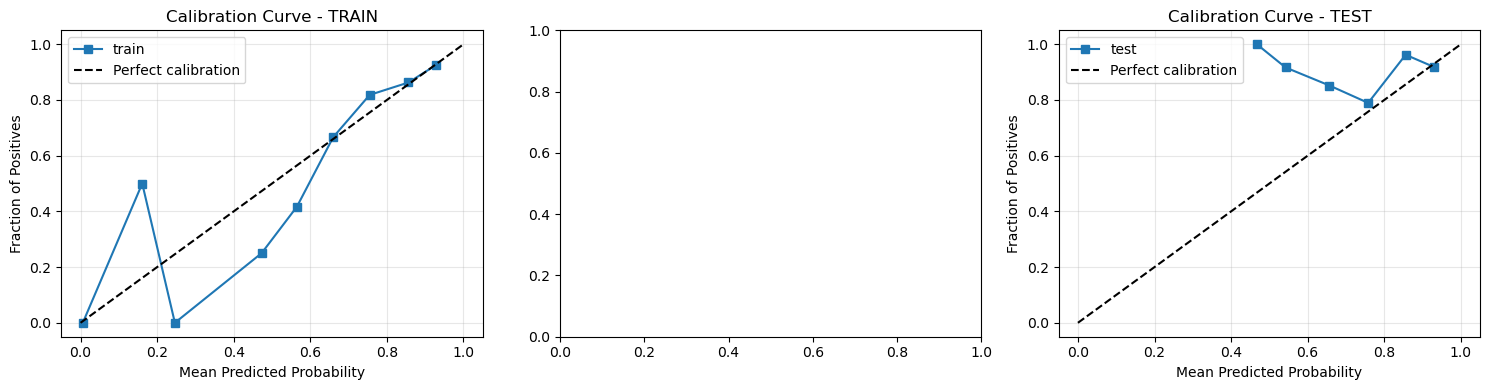

In [44]:
# 9. 绘制校准曲线

def plot_calibration_curve(results, save_path: Path = None):
    """绘制概率校准曲线"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    splits = ['train', 'val', 'test']
    
    for idx, split_name in enumerate(splits):
        if split_name not in results:
            continue
            
        y_true = results[split_name]['y_true']
        y_pred_proba = results[split_name]['y_pred_proba']
        
        # 校准曲线
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_pred_proba, n_bins=10
        )
        
        ax = axes[idx] if len(splits) > 1 else axes
        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=split_name)
        ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
        ax.set_xlabel("Mean Predicted Probability")
        ax.set_ylabel("Fraction of Positives")
        ax.set_title(f"Calibration Curve - {split_name.upper()}")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"校准曲线已保存到: {save_path}")
    
    plt.show()

# 如果有 results，绘制校准曲线
plot_calibration_curve(results, save_path=PROJECT_ROOT / "data" / "calibration_curve.png")

In [1]:
# 10. 生成最终概率结果表（每家公司、每个季度）

def generate_probability_table(df_model, results, selected_features):
    """
    生成最终的概率结果表，包含：
    - Ticker
    - Fiscal Quarter
    - 预测 Beat 概率
    - 实际 Beat/Miss
    - 样本内/样本外标记
    """
    model = results['model']
    scaler = results['scaler']
    
    # 为所有数据生成预测
    X_all = df_model[selected_features].fillna(0)
    X_all_scaled = scaler.transform(X_all)
    all_probs = model.predict_proba(X_all_scaled)[:, 1]
    
    # 确定样本内/样本外
    df_model['year'] = df_model['fiscal_quarter'].str.extract(r'(\d{4})').astype(int)
    df_model['is_out_of_sample'] = df_model['year'] > 2023  # 根据你的切分调整
    
    # 创建结果表（若 model_data 无 call_datetime_et 则用空字符串占位）
    call_dt = df_model['call_datetime_et'] if 'call_datetime_et' in df_model.columns else pd.Series('', index=df_model.index)
    df_results = pd.DataFrame({
        'ticker': df_model['ticker'],
        'fiscal_quarter': df_model['fiscal_quarter'],
        'call_datetime_et': call_dt,
        'predicted_beat_prob': all_probs,
        'actual_beat': df_model['eps_beat'],
        'actual_label': df_model['eps_beat'].map({1: 'Beat', 0: 'Miss'}),
        'is_out_of_sample': df_model['is_out_of_sample']
    })
    
    # 保存到 CSV
    output_path = PROJECT_ROOT / "data" / "beat_probability_results.csv"
    df_results.to_csv(output_path, index=False)
    print(f"\n概率结果表已保存到: {output_path}")
    print(f"共 {len(df_results)} 条记录")
    print(f"样本内: {len(df_results[~df_results['is_out_of_sample']])} 条")
    print(f"样本外: {len(df_results[df_results['is_out_of_sample']])} 条")
    
    return df_results

# 如果有数据，生成结果表
df_results = generate_probability_table(df_model, results, selected_features)

NameError: name 'df_model' is not defined

## 11. 打印模型详细信息

In [ ]:
# ========== 打印模型详细信息 ==========

if 'results' in globals() and results is not None:
    model = results['model']
    scaler = results['scaler']
    
    print("=" * 80)
    print("模型详细信息")
    print("=" * 80)
    
    # 1. 模型类型和基本信息
    print("\n【1. 模型类型】")
    print(f"  模型类型: {type(model).__name__}")
    print(f"  模型类: {type(model)}")
    
    # 2. 模型参数
    print("\n【2. 模型参数】")
    print(f"  C (正则化强度): {model.C}")
    print(f"  penalty (惩罚项): {model.penalty}")
    print(f"  max_iter (最大迭代次数): {model.max_iter}")
    print(f"  random_state (随机种子): {model.random_state}")
    print(f"  solver (求解器): {model.solver}")
    print(f"  tol (收敛容差): {model.tol}")
    print(f"  fit_intercept (是否拟合截距): {model.fit_intercept}")
    print(f"  class_weight (类别权重): {model.class_weight}")
    
    # 3. 模型结构
    print("\n【3. 模型结构】")
    print(f"  特征数量: {len(model.coef_[0])}")
    print(f"  类别数量: {len(model.classes_)}")
    print(f"  类别标签: {model.classes_}")
    print(f"  截距 (intercept): {model.intercept_[0]:.6f}")
    
    # 4. 使用的特征列表
    print("\n【4. 使用的特征列表】")
    if 'selected_features' in globals():
        print(f"  特征总数: {len(selected_features)}")
        print("\n  特征列表:")
        for i, feat in enumerate(selected_features, 1):
            print(f"    {i:2d}. {feat}")
    else:
        print("  ⚠️ 未找到 selected_features 变量")
    
    # 5. 特征系数（权重）
    print("\n【5. 特征系数（权重）】")
    if 'selected_features' in globals() and 'feature_importance' in globals():
        print("\n  所有特征的系数（按绝对值排序）:")
        print(feature_importance.to_string(index=False))
    else:
        print("\n  特征系数:")
        coef_df = pd.DataFrame({
            'feature': selected_features if 'selected_features' in globals() else [f'feature_{i}' for i in range(len(model.coef_[0]))],
            'coefficient': model.coef_[0],
            'abs_coefficient': np.abs(model.coef_[0])
        }).sort_values('abs_coefficient', ascending=False)
        print(coef_df.to_string(index=False))
    
    # 6. Scaler 信息
    print("\n【6. 特征标准化器 (StandardScaler)】")
    print(f"  类型: {type(scaler).__name__}")
    print(f"  均值 (mean): {scaler.mean_[:5] if len(scaler.mean_) > 5 else scaler.mean_}...")
    print(f"  标准差 (scale): {scaler.scale_[:5] if len(scaler.scale_) > 5 else scaler.scale_}...")
    print(f"  特征数量: {len(scaler.mean_)}")
    
    # 7. 模型预测函数
    print("\n【7. 模型预测函数】")
    print(f"  predict(): 预测类别（0或1）")
    print(f"  predict_proba(): 预测概率 [P(Miss), P(Beat)]")
    print(f"  decision_function(): 决策函数值（未归一化的概率）")
    
    # 8. 训练数据统计
    print("\n【8. 训练数据统计】")
    if 'df_train' in globals():
        print(f"  训练样本数: {len(df_train)}")
        print(f"  训练集 Beat 比例: {df_train['eps_beat'].mean():.2%}")
        print(f"  训练集 Beat 数量: {df_train['eps_beat'].sum()}")
        print(f"  训练集 Miss 数量: {(df_train['eps_beat'] == 0).sum()}")
    
    # 9. 模型文件路径
    print("\n【9. 保存的模型文件】")
    model_path = PROJECT_ROOT / "data" / "model.pkl"
    scaler_path = PROJECT_ROOT / "data" / "scaler.pkl"
    features_path = PROJECT_ROOT / "data" / "selected_features.txt"
    print(f"  模型文件: {model_path} ({'✅ 存在' if model_path.exists() else '❌ 不存在'})")
    print(f"  Scaler 文件: {scaler_path} ({'✅ 存在' if scaler_path.exists() else '❌ 不存在'})")
    print(f"  特征列表文件: {features_path} ({'✅ 存在' if features_path.exists() else '❌ 不存在'})")
    
    print("\n" + "=" * 80)
    print("模型信息打印完成")
    print("=" * 80)
    
else:
    print("❌ 未找到训练好的模型，请先运行模型训练的 cell")

## 12. 数据泄漏和切分问题检查

In [ ]:
# ========== 数据泄漏和切分问题检查 ==========

print("=" * 80)
print("数据泄漏和切分问题检查")
print("=" * 80)

# 检查1: Test set大小和分布
print("\n【检查1: Test set大小和分布】")
if 'df_test' in globals() and df_test is not None:
    print(f"  Test set 总样本数: {len(df_test)}")
    if 'eps_beat' in df_test.columns:
        beat_count = df_test['eps_beat'].sum()
        miss_count = len(df_test) - beat_count
        print(f"  Test set Beat 数量: {beat_count}")
        print(f"  Test set Miss 数量: {miss_count}")
        print(f"  Test set Beat 比例: {df_test['eps_beat'].mean():.2%}")
        
        if beat_count < 5 or miss_count < 5:
            print(f"  ⚠️ 警告: Test set中Beat或Miss数量太少（<5），结果可能不稳定")
        else:
            print(f"  ✅ Test set样本分布合理")
    else:
        print("  ⚠️ 警告: df_test中没有eps_beat列")
else:
    print("  ❌ 未找到df_test，请先运行时间序列切分")

# 检查2: 同一季度是否同时出现在train和test
print("\n【检查2: 同一季度是否同时出现在train和test】")
if 'df_train' in globals() and 'df_test' in globals():
    train_quarters = set(df_train['fiscal_quarter'].astype(str).unique())
    test_quarters = set(df_test['fiscal_quarter'].astype(str).unique())
    overlap = train_quarters & test_quarters
    
    if len(overlap) > 0:
        print(f"  ❌ 严重问题: 有{len(overlap)}个季度同时出现在train和test中:")
        for q in sorted(overlap):
            train_tickers = set(df_train[df_train['fiscal_quarter'].astype(str)==q]['ticker'].unique())
            test_tickers = set(df_test[df_test['fiscal_quarter'].astype(str)==q]['ticker'].unique())
            common_tickers = train_tickers & test_tickers
            if len(common_tickers) > 0:
                print(f"    季度 {q}: {sorted(common_tickers)} 同时出现在train和test")
    else:
        print(f"  ✅ 没有季度同时出现在train和test中")
        print(f"  Train季度数: {len(train_quarters)}")
        print(f"  Test季度数: {len(test_quarters)}")
else:
    print("  ❌ 未找到df_train或df_test")

# 检查3: 特征选择是否在切分之前（数据泄漏）
print("\n【检查3: 特征选择是否使用了test set数据（数据泄漏）】")
print("  检查逻辑: 如果select_features在split_time_series之前调用，且使用了整个df_model，")
print("           则存在数据泄漏（特征选择时看到了test set）")
print("  ⚠️ 注意: 需要手动检查代码执行顺序")
print("  - 如果先执行 select_features(df_model)，再执行 split_time_series(df_model)")
print("    则存在数据泄漏：特征选择时看到了test set的数据")
print("  - 正确做法：先切分，再在train set上选择特征")

# 检查4: Label对齐问题（时间泄漏）
print("\n【检查4: Label对齐问题（时间泄漏）】")
print("  检查逻辑: Label应该是'当前季度call预测下个季度beat'")
if 'df_model' in globals() and df_model is not None:
    # 检查是否有fiscal_quarter和eps_beat的异常对齐
    sample = df_model[['ticker', 'fiscal_quarter', 'eps_beat']].head(10)
    print("  前10行数据示例:")
    print(sample.to_string(index=False))
    print("  ⚠️ 需要手动验证: eps_beat是否对应'下个季度'的beat，而不是'当前季度'")
    print("  正确逻辑: Q1 2024的call → Q2 2024的beat/miss")
else:
    print("  ❌ 未找到df_model")

# 检查5: Train和Test的分布一致性
print("\n【检查5: Train和Test的分布一致性】")
if 'df_train' in globals() and 'df_test' in globals():
    if 'eps_beat' in df_train.columns and 'eps_beat' in df_test.columns:
        train_beat_rate = df_train['eps_beat'].mean()
        test_beat_rate = df_test['eps_beat'].mean()
        diff = abs(train_beat_rate - test_beat_rate)
        
        print(f"  Train Beat比例: {train_beat_rate:.2%}")
        print(f"  Test Beat比例: {test_beat_rate:.2%}")
        print(f"  差异: {diff:.2%}")
        
        if diff > 0.15:  # 15%的差异阈值
            print(f"  ⚠️ 警告: Train和Test的Beat比例差异较大（>{15:.0f}%），可能存在分布不一致")
        else:
            print(f"  ✅ Train和Test的Beat比例差异在可接受范围内")
        
        # 检查ticker分布
        train_tickers = set(df_train['ticker'].unique())
        test_tickers = set(df_test['ticker'].unique())
        if train_tickers != test_tickers:
            print(f"  ⚠️ 警告: Train和Test包含的ticker不一致")
            print(f"    Train tickers: {sorted(train_tickers)}")
            print(f"    Test tickers: {sorted(test_tickers)}")
        else:
            print(f"  ✅ Train和Test包含相同的ticker")
    else:
        print("  ❌ 无法检查：缺少eps_beat列")
else:
    print("  ❌ 未找到df_train或df_test")

# 检查6: 是否有fiscal_quarter特征（不应该有）
print("\n【检查6: 是否有fiscal_quarter作为特征（数据泄漏）】")
if 'selected_features' in globals():
    if 'fiscal_quarter' in selected_features:
        print(f"  ❌ 严重问题: fiscal_quarter被选为特征，这是时间泄漏！")
    else:
        print(f"  ✅ fiscal_quarter不在特征列表中")
else:
    print("  ⚠️ 未找到selected_features，无法检查")

# 检查7: Delta特征的计算是否使用了未来数据
print("\n【检查7: Delta特征的计算是否使用了未来数据】")
print("  检查逻辑: delta_net_sentiment和delta_complexity使用滚动窗口计算")
print("  ⚠️ 需要手动验证: 这些特征的计算是否只使用了历史数据（当前季度之前的数据）")
print("  正确做法: 对于季度i，delta特征应该只使用季度1到i-1的数据计算")

print("\n" + "=" * 80)
print("检查完成")
print("=" * 80)